# Code

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
import random
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

from util.create_nt_datasets_utils import *

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
    clean_nt_dataframes_before_class_input,
    get_features1,
    get_features2, 
    get_full_overlap_features1,
    get_full_overlap_features2,
)
from config import *

In [2]:
how = 'ricseq'

In [20]:
if how == 'splash':
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
elif how in ['mario', 'ricseq']:
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))

In [21]:
drop_treshold = 10 #avoid hardneg creation problems
if how == 'ricseq':
    original_shape = df.shape[0]
    excluding_conditions = ((df.length_1 - df.w) < drop_treshold) | ((df.length_2 - df.h) < drop_treshold)
    df = df[~excluding_conditions].reset_index(drop = True)
    print('# dropped = ', original_shape - df.shape[0])

# dropped =  4


In [22]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

2 genes have N, so will be excluded


limit of small rna is: 7000
limit of medium rna is: 8500


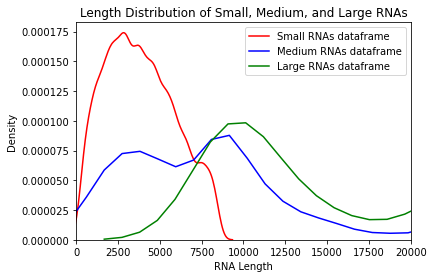

The amount of contact matrixes (in the entire dataset) that are small is 61.3% 
The amount of contact matrixes (in the entire dataset) that are medium is 33.4% 
The amount of contact matrixes (in the entire dataset) that are big is 5.4% 


In [23]:
df_small, df_medium, df_big = get_df_small_medium_big(df, limit_small_rna = 7_000, limit_medium_rna = 8_500, plot_distributions=True)

perc_small, perc_medium, perc_big = calc_perc_small_medium_big(df_small.shape[0],df_medium.shape[0],df_big.shape[0], df.shape[0])

In [24]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE, MAX_RNA_SIZE + 1): float(1),}
neg_height_windows = neg_width_windows

In [25]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=0
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=1
sn_per_sample_medium=1
en_per_sample_medium=0
hn_per_sample_medium=0


#big policies
ep_per_sample_big=1
sn_per_sample_big=1
en_per_sample_big=1
hn_per_sample_big=1

In [26]:
tot_ep = ep_per_sample_small*perc_small + ep_per_sample_medium*perc_medium + ep_per_sample_big*perc_big
tot_sn = sn_per_sample_small*perc_small + sn_per_sample_medium*perc_medium + sn_per_sample_big*perc_big
tot_en = en_per_sample_small*perc_small + en_per_sample_medium*perc_medium + en_per_sample_big*perc_big
tot_hn = hn_per_sample_small*perc_small + hn_per_sample_medium*perc_medium + hn_per_sample_big*perc_big

tot_neg = tot_sn + tot_en + tot_hn
print(f'expected smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'expected easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'expected hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

unbalanced_factor = df[df.interacting == False].shape[0]/df.shape[0]
expected_uf = tot_ep*unbalanced_factor / ((tot_ep*unbalanced_factor) + tot_neg)
print(f'expected unbalanced factor is {np.round(expected_uf*100, 2)}%')

expected smartneg are the 90.26% of negative pairs
expected easyneg are the 4.87% of negative pairs
expected hardneg are the 4.87% of negative pairs
expected unbalanced factor is 28.77%


# Data Loader val

In [70]:
subset_file = ''

meta = {}
id_couple = 0

In [71]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    # if np.random.rand() < 0.01:
    #     print(sample.gene1_info['length'])
    #     print(sample.bbox.x1, sample.bbox.x2)
    #     print(sample.seed_interaction_bbox.x1, sample.seed_interaction_bbox.x2)
    #     print(sample.gene2_info['length'])
    #     print(sample.bbox.y1, sample.bbox.y2)
    #     print(sample.seed_interaction_bbox.y1, sample.seed_interaction_bbox.y2)
    #     print('\n\n')
    #     plot_sample(sample, True)
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/1993 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Total time to create datasets: 0.015488553047180175 minutes


In [48]:
df_meta.to_csv(os.path.join(metadata_dir, f'{how}.csv'), index = False)

# Create the embedding query

In [49]:
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))

In [50]:
def create_query_df(df):
    df1 = df[['id_gene1_sample', 'cdna1']].drop_duplicates().rename({'id_gene1_sample':'id_query', 'cdna1':'cdna'}, axis = 1)
    df2 = df[['id_gene2_sample', 'cdna2']].drop_duplicates().rename({'id_gene2_sample':'id_query', 'cdna2':'cdna'}, axis = 1)
    df = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)
    return df

In [51]:
df_query = create_query_df(df_meta).drop_duplicates().reset_index(drop = True)

In [52]:
query = set(df_meta['id_gene1_sample']).union(df_meta['id_gene2_sample'])

#the 2 assert below also means that there are unique cdna per id_query
assert len(df_query.id_query) == len(query)
assert set(df_query.id_query) == query

In [53]:
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [34]:
df_query.to_csv(os.path.join(metadata_dir, f'embedding_query.csv'), index = False)

In [105]:
estimate_time_and_space(df_query.shape[0])

estimated # hours: 0.45
estimated # days: 0.02
estimated terabytes (pessimistic): 0.02
estimated terabytes (realistic): 0.01


In [98]:
# Usage example
directory_path = os.path.join(embedding_dir)
print_size = False
if print_size:
    directory_size = get_directory_size(directory_path)
    print(directory_size)

# Create df_genes_nt and df_nt

In [72]:
#import data 
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))

In [73]:
df_meta = swap_if_needed(df_meta)

In [74]:
assert len(set(df_meta.id_sample)) == len(df_meta)

In [75]:
df_meta['couples_id'] = df_meta['couples']
df_meta['couples'] = df_meta['id_sample']


print(f'{how}:', len(list(set(df_meta.couples))))

splash: 2031


#### Drop the small couples

In [76]:
min_len = 25

original_shape = df_meta.shape[0]
df_meta = df_meta[~((df_meta.length_1 < min_len) | (df_meta.length_2 < min_len))].reset_index(drop = True)
print('# dropped = ', original_shape - df_meta.shape[0])

# dropped =  0


##### Create fake_interaction_region

In [77]:
#create fake_interaction_region
interaction_size=16

df_meta = create_fake_interaction_region(df_meta, interaction_size=16)

assert (df_meta.x2<=df_meta.length_1).all()

assert (df_meta.x1>=0).all()


subset = df_meta[df_meta.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()

In [78]:
df_full = df_meta

df_nt = clean_df_nt(df_full)

df_nt.to_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'), index = False)

In [79]:
df_genes_nt = create_df_genes_nt(df_full)

In [80]:
assert set(df.gene1).union(df.gene2) == set(df_full.gene1).union(df_full.gene2)
assert set(df_genes_nt.original_gene_id) - set(df_genes.gene_id) == set()

In [81]:
df_genes_nt.to_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'), index = False)

### Add experiment column
Ho bisogno di sapere a quale id dell esperimento corrisponde ogni riga del dataset

In [82]:
df = pd.read_csv(os.path.join(processed_files_dir, f"{how}.csv"))
df_nt = pd.read_csv(os.path.join(metadata_dir,  f'df_nt_{how}.csv'))

df['x2'] = df['x1'] + df['w']
df['y2'] = df['y1'] + df['h']
df = df.rename({'couples':'couples_id', 'x1':'original_x1', 'x2':'original_x2', 'y1':'original_y1', 'y2':'original_y2'}, axis = 1)

if how == 'splash':
    df = df[['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2', 'experiment', 'where_x1', 'where_y1', 'where']]

elif how in ['mario', 'ricseq']:
    df = df[['couples_id', 'original_x1', 'original_x2', 
             'original_y1', 'original_y2', 'name', 'other_id', 
             'experiment', 'simple_repeats', 'sine_alu', 'low_complex', 
             'n_reads', 'is_merged', 'where_x1', 'where_y1', 'where']]
df_nt_new = df_nt.merge(df, on = ['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2'])
df_nt_new = df_nt_new.drop_duplicates(['couples'])

todo = df_nt[df_nt.couples.isin(set(df_nt.couples) - set(df_nt_new.couples))]
todogenes = todo.couples_id.str.extractall('(.*)_(.*)').reset_index()
assert ( todogenes[0] == todogenes[1] ).all()

todo.couples.all
#they are negative but they are the same rnarna thats why they didnt metch

todo = todo.rename({
    'original_x1':'original_y1', 
    'original_x2':'original_y2', 
    'original_y1':'original_x1', 
    'original_y2':'original_x2', 
}, axis = 1)

last = todo.merge(df, on = ['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2'])
last = last.drop_duplicates(['couples'])
df_nt_new = pd.concat([df_nt_new, last], axis = 0).reset_index(drop = True)

assert set(df_nt_new.couples) == set(df_nt.couples)
assert df_nt_new.shape[0] == df_nt.shape[0] 

df_nt_new.to_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'), index = False)

# Check the data saved

In [21]:
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f"{how}.csv"))

assert max(df_meta.length_1.max(), df_meta.length_2.max()) == MAX_RNA_SIZE

In [22]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

In [23]:
# all the excluded couples belonw are few (should be zero)
not_in_df = set(df.couples) - set(df_nt.couples_id) 
print(len(df[df.couples.isin(not_in_df)]))
assert len(df[df.couples.isin(not_in_df)]) < 20

0


### Plot embedding lengths based on policy

In [13]:
df_nt.policy.value_counts()/df_nt.shape[0] * 100

easypos     53.471196
smartneg    46.479567
hardneg      0.049237
Name: policy, dtype: float64

All the embedding lengths for policy hardneg are equal to 5970


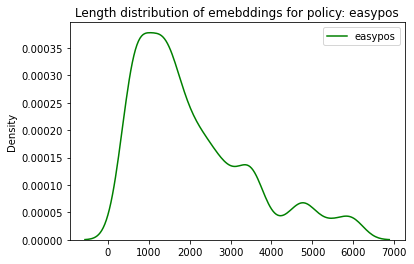

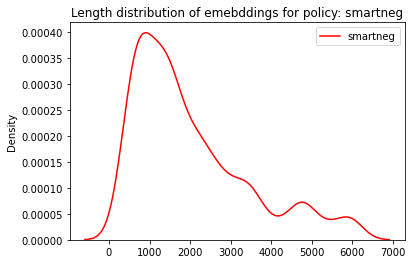

In [14]:
plot_embedding_lengths_based_on_policy(df_nt)

### Plot position of the embeddings based on each class (pos, smartneg, easyneg, hardneg)

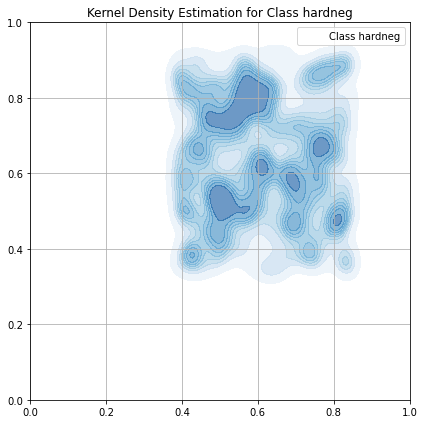

In [ ]:
plot_embeddings_position_based_on_policy(df_nt, df_genes_nt, n_to_sample_from_each_class = 1_000)

### Cheks

In [24]:
assert (df_nt.x1 >= 0).all()
assert (df_nt.y1 >= 0).all()
assert ((df_nt.x1 + df_nt.w) <= df_nt.length_1).all()
assert ((df_nt.y1 + df_nt.h) <= df_nt.length_2).all()
assert df_genes_nt.apply(lambda x: len(x.cdna) == (x.window_c2-x.window_c1), axis = 1).all()

In [25]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE, MAX_RNA_SIZE+1): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

In [26]:
dataset = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file='',
        augment_policies=policies,
)

In [27]:
all_couples = set(df.couples)

for s in tqdm(dataset):
    interacting, actual_policy = s.interacting, s.policy

    couple_id = s.gene1_info['original_gene_id'] + '_' + s.gene2_info['original_gene_id']
    couple_id_swapped = s.gene2_info['original_gene_id'] + '_' + s.gene1_info['original_gene_id']
    
    if couple_id in all_couples:
        gene1_id, gene2_id = s.gene1, s.gene2
        gene1_info, gene2_info = s.gene1_info, s.gene2_info
        real_couple_id = couple_id
        actual_window_x1, actual_window_x2 = s.bbox.x1, s.bbox.x2
        actual_window_y1, actual_window_y2 = s.bbox.y1, s.bbox.y2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    elif couple_id_swapped in all_couples:
        gene2_id, gene1_id = s.gene1, s.gene2
        gene2_info, gene1_info = s.gene1_info, s.gene2_info
        actual_window_y1, actual_window_y2 = s.bbox.x1, s.bbox.x2
        actual_window_x1, actual_window_x2 = s.bbox.y1, s.bbox.y2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
        real_couple_id = couple_id_swapped
    else:
        raise NotImplementedError
        
    original_gene_id1, original_gene_id2 = gene1_info['original_gene_id'], gene2_info['original_gene_id']
    cdna_slice1, cdna_slice2 = gene1_info['cdna'], gene2_info['cdna']
    window_x1, window_x2 = gene1_info['window_c1'], gene1_info['window_c2']
    window_y1, window_y2 = gene2_info['window_c1'], gene2_info['window_c2']
    protein_coding1, protein_coding2 = gene1_info['protein_coding'], gene2_info['protein_coding']
    original_length1, original_length2 = gene1_info['original_length'], gene2_info['original_length']
    
    policy_res = [
        i['policy'] for i in s.gene1_info['interactions'] if 
        (i['couples_id']==real_couple_id)&
        ( set([i['gene1'],i['gene2']])==set([s.gene1, s.gene2]) )
    ]
    
    assert (len(set(policy_res)) == 1) | (set(policy_res) == {'smartneg', 'easyneg'})
    policy = policy_res[0]
        
    assert gene1_id == gene1_info['gene_id']
    assert gene2_id == gene2_info['gene_id']
    assert window_x2-window_x1 == len(cdna_slice1)
    assert window_y2-window_y1 == len(cdna_slice2)
    
    real1 = df_genes[df_genes.gene_id == original_gene_id1].iloc[0]
    real2 = df_genes[df_genes.gene_id == original_gene_id2].iloc[0]

    assert real1['cdna'][window_x1:window_x2] == cdna_slice1
    assert real2['cdna'][window_y1:window_y2] == cdna_slice2
    assert real1.protein_coding == protein_coding1
    assert real2.protein_coding == protein_coding2
    
    real_df = df[df.couples == real_couple_id].iloc[0]
    if policy == 'easypos':
        assert real_df.interacting == interacting == True
        assert actual_policy == 'easypos'
    if policy == 'hardneg':
        assert real_df.interacting == True
        assert interacting == False
        assert actual_policy == 'smartneg'
    elif policy in ['smartneg', 'easyneg']:
        assert real_df.interacting == interacting == False
        assert actual_policy == 'smartneg'
    assert real_df.protein_coding_1 == protein_coding1
    assert real_df.protein_coding_2 == protein_coding2
        
    real_x1, real_x2, real_interaction_x1, real_interaction_x2 = map_coordinates(window_x1, window_x2, actual_window_x1, actual_window_x2, actual_interaction_x1, actual_interaction_x2)
    real_y1, real_y2, real_interaction_y1, real_interaction_y2 = map_coordinates(window_y1, window_y2, actual_window_y1, actual_window_y2, actual_interaction_y1, actual_interaction_y2)

    assert real_x1>=0
    assert real_y1>=0
    assert real_x1<=real_x2<=original_length1
    assert real_y1<=real_y2<=original_length2

    if (policy == 'easypos')|(policy == 'smartneg'):
        assert real_x1<=real_interaction_x1<=real_interaction_x2
        assert real_interaction_x1<=real_interaction_x2<=real_x2
        assert real_y1<=real_interaction_y1<=real_interaction_y2
        assert real_interaction_y1<=real_interaction_y2<=real_y2
    elif policy == 'hardneg':
        # le coordinate real_x1, real_x2 non sono piu buone perche avevo sovrascritto le regioni di interazione di hardneg e easyneg
        real_x1, real_x2 = real_df.x1, real_df.x1+real_df.w
        real_y1, real_y2 = real_df.y1, real_df.y1+real_df.h
        assert ( 
            (real_interaction_x2 < real_x1)|(real_interaction_x1 > real_x2) | 
            (real_interaction_y2 < real_y1)|(real_interaction_y1 > real_y2) 
        )

  0%|          | 0/2348 [00:00<?, ?it/s]

```
original      0, 10, 20, 23,24, 50, 70, 100
window           10                 70
actual_win           10         40
actual_int               13,14
```

### Check embeddings

In [28]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

[autoreload of dataset.data failed: Traceback (most recent call last):
  File "/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [29]:
vc_train = df_nt.interacting.value_counts()

if vc_train[False]>vc_train[True]:
    unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]
    interacting_greater = False
else:
    unbalance_factor = 1 - (vc_train[True] - vc_train[False]) / vc_train[True]
    interacting_greater = True

pos_width_multipliers = {10_000_000: 1.}

pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE, MAX_RNA_SIZE+1): float(1),}
neg_height_windows = neg_width_windows

if interacting_greater:
    policies = [
        EasyPosAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
        ),  
        SmartNegAugment(
            per_sample=1,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
    ]
else:
    policies = [
        EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
        ),  
        SmartNegAugment(
            per_sample=unbalance_factor,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
    ]
    

dataset = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file='',
        augment_policies=policies,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = 20,
        min_n_groups = 5,
        max_n_groups = 80,
)

In [30]:
l1_neg, l2_neg, l1_pos, l2_pos = [], [], [], []

for s in tqdm(dataset):
    length1, length2 = s.bbox.x2-s.bbox.x1, s.bbox.y2-s.bbox.y1
    if s.interacting:
        l1_pos.append(length1)
        l2_pos.append(length2)
    else:
        l1_neg.append(length1)
        l2_neg.append(length2)

  0%|          | 0/2162 [00:00<?, ?it/s]

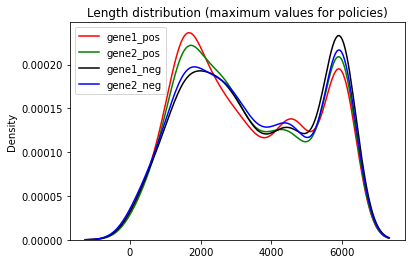

In [31]:
sns.kdeplot(l1_pos, color = 'red', label = 'gene1_pos')
sns.kdeplot(l2_pos, color = 'green', label = 'gene2_pos')
sns.kdeplot(l1_neg, color = 'black', label = 'gene1_neg')
sns.kdeplot(l2_neg, color = 'blue', label = 'gene2_neg')
plt.title(f'Length distribution (maximum values for policies)')
plt.legend()
plt.show()

# Download test set 200 nucleotides

In [7]:
MAX_RNA_SIZE_TEST = 200

test500_path = os.path.join(metadata_dir, f'{how}{MAX_RNA_SIZE_TEST}.csv')

In [8]:
import util.misc as utils
import shutil

def load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_BERT):
    source_file_path = os.path.join(dataset_files_dir, 'data.py')
    data_bert_file_path = os.path.join(dataset_files_dir, 'data_bert.py')
    shutil.copy(source_file_path, data_bert_file_path)
    new_max_rna_length = MAX_RNA_SIZE_BERT

    # Read the content of data_bert.py
    with open(data_bert_file_path, 'r') as file:
        lines = file.readlines()

    # Find and modify the MAX_RNA_LENGTH line
    modified_lines = []
    for line in lines:
        if line.startswith('MAX_RNA_SIZE'):
            modified_lines.append(f'MAX_RNA_SIZE = {new_max_rna_length}\n')
        else:
            modified_lines.append(line)

    # Write the modified content back to data_bert.py
    with open(data_bert_file_path, 'w') as file:
        file.writelines(modified_lines)
        
load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_TEST)

from dataset.data_bert import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    SmartNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    create_augment_list,
    plot_sample,
    seed_everything,
)


<class 'transformers.tokenization_dna.DNATokenizer'>


In [9]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
#leva quelli con regione di interazione maggiore di MAX_RNA_SIZE_TEST
df_nt = df_nt[~((df_nt.w>=MAX_RNA_SIZE_TEST)|(df_nt.h>=MAX_RNA_SIZE_TEST))]

df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))
df_nt, df_genes_nt = clean_nt_dataframes_before_class_input(df_nt, df_genes_nt)


pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

neg_windows = {(MAX_RNA_SIZE_TEST, MAX_RNA_SIZE_TEST+1): 1.}

policies_test = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
    HardNegAugment(
        per_sample=1,
        width_windows=neg_windows,
        height_windows=neg_windows,
    ),
    EasyNegAugment(
        per_sample=1,
        width_windows=neg_windows,
        height_windows=neg_windows,
    ),
]

dataset_test = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file='',
    augment_policies=policies_test,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = 5,
    min_n_groups = np.nan,
    max_n_groups = 80,
)

In [10]:
test500 = []

for s in tqdm(dataset_test):
    
    gene1, gene2 = s.gene1, s.gene2

    x1, x2, y1, y2 = s.bbox.x1, s.bbox.x2, s.bbox.y1, s.bbox.y2

    seed_x1, seed_x2, seed_y1, seed_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2, s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    
    interacting = s.interacting

    cdna1, cdna2 = s.gene1_info['cdna'], s.gene2_info['cdna']

    cdna1slice, cdna2slice = cdna1[x1:x2], cdna2[y1:y2]
    
    assert len(s.all_couple_interactions) == 1
    couples_id = s.all_couple_interactions[0]['couple']
    
    policy = get_test_policy(s.all_couple_interactions[0]['policy'], s.policy)

    test500.append({
        'gene1':gene1,
        'gene2':gene2,
        'x1':x1,
        'x2':x2,
        'y1':y1,
        'y2':y2,
        'seed_x1':seed_x1,
        'seed_x2':seed_x2,
        'seed_y1':seed_y1,
        'seed_y2':seed_y2,
        'cdna1':cdna1slice,
        'cdna2':cdna2slice,
        'len1':len(cdna1slice),
        'len2':len(cdna2slice),
        'couples':couples_id,
        'policy':policy
    })
    
test500 = pd.DataFrame(test500)
assert test500.len1.max() == test500.len2.max() == MAX_RNA_SIZE_TEST
n_rows = test500.shape[0]

  0%|          | 0/4556 [00:00<?, ?it/s]

In [11]:
p_sn = test500[test500.policy.isin(['smartneg', 'easypos'])]

assert (p_sn.x1 <= p_sn.seed_x1).all()
assert (p_sn.seed_x1 <= p_sn.seed_x2).all()
assert (p_sn.seed_x2 <= p_sn.x2).all()
assert (p_sn.y1 <= p_sn.seed_y1).all()
assert (p_sn.seed_y1 <= p_sn.seed_y2).all()
assert (p_sn.seed_y2 <= p_sn.y2).all()

In [12]:
test500_1 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2', 'couples'], right_on = ['gene1', 'gene2', 'couples'])
test500_2 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2', 'couples'], right_on = ['gene2', 'gene1', 'couples'])

test500_2 = test500_2.drop(['gene1_x', 'gene2_x'], axis = 1).rename({'gene1_y':'gene1', 'gene2_y':'gene2'}, axis = 1)
where = test500_2.len1>0 #all rows
test500_2.loc[where, ['x1', 'y1']] = (test500_2.loc[where, ['y1', 'x1']].values)
test500_2.loc[where, ['x2', 'y2']] = (test500_2.loc[where, ['y2', 'x2']].values)
test500_2.loc[where, ['seed_x1', 'seed_y1']] = (test500_2.loc[where, ['seed_y1', 'seed_x1']].values)
test500_2.loc[where, ['seed_x2', 'seed_y2']] = (test500_2.loc[where, ['seed_y2', 'seed_x2']].values)
test500_2.loc[where, ['len1', 'len2']] = (test500_2.loc[where, ['len2', 'len1']].values)
test500_2.loc[where, ['cdna1', 'cdna2']] = (test500_2.loc[where, ['cdna2', 'cdna1']].values)

#shuffling
test500 = pd.concat([test500_1, test500_2], axis = 0).sample(frac=1).reset_index(drop = True)

#clean gene_name_column
test500['gene1'] = test500['gene1'].str.extractall('(.*)_(.*)').reset_index()[0]
test500['gene2'] = test500['gene2'].str.extractall('(.*)_(.*)').reset_index()[0]

#clean gene_name_column
df_nt['gene1'] = df_nt['gene1'].str.extractall('(.*)_(.*)').reset_index(1)[0]
df_nt['gene2'] = df_nt['gene2'].str.extractall('(.*)_(.*)').reset_index(1)[0]

In [13]:
assert df_nt[df_nt.duplicated(set(df_nt.columns) - {'couples'})].shape[0] < df_nt.shape[0]*0.01

print('NB There are ', abs(n_rows - test500.shape[0]), ' duplicated in df_nt (i think they are easyneg and smartneg overlapping)')
# with respect to this key 
# df_nt['key'] = df_nt['gene1'] + '_' + df_nt['gene2'] 
# but they are few
# df_nt[(df_nt['gene1'] + '_' + df_nt['gene2']).duplicated()]

NB There are  0  duplicated in df_nt (i think they are easyneg and smartneg overlapping)


### Drop secondary structure couples

In [14]:
test500['g1'] = test500['gene1'].str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
test500['g2'] = test500['gene2'].str.extractall('(.*)_(.*)_(.*)').reset_index()[0]

test500 = test500[~(test500.g1 == test500.g2)].reset_index(drop = True)
test500.to_csv(test500_path, index = False)

### Add the distance to the colosest region of interaction 

In [15]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

In [16]:
gene1_coord = test500['gene1'].str.extractall('(.*)_(.*)_(.*)').reset_index()
gene2_coord = test500['gene2'].str.extractall('(.*)_(.*)_(.*)').reset_index()

test500['start_window_x'] = gene1_coord[1].astype(int) + test500['x1']
test500['end_window_x'] = gene1_coord[1].astype(int) + test500['x2']

test500['start_window_y'] = gene2_coord[1].astype(int) + test500['y1']
test500['end_window_y'] = gene2_coord[1].astype(int) + test500['y2']

In [17]:
diz = {}
for _, row in tqdm(test500.iterrows(), total = test500.shape[0]):
    g1, g2 = row.g1, row.g2
    x1,x2,y1,y2 = row.start_window_x, row.end_window_x, row.start_window_y, row.end_window_y

    couple_name = g1 + '_' + g2
    assert couple_name in set(df.couples)

    all_interactions = df[df['couples'] == couple_name]

    distances_x = []
    distances_y = []
    for __, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x1 + df_row.w])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y1 + df_row.h])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[_] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/4550 [00:00<?, ?it/s]

In [18]:
distances = pd.DataFrame.from_dict(diz, orient = 'index').reset_index(drop = True)
test500 = pd.concat([test500, distances], axis = 1)

In [19]:
test500[(test500.policy == 'smartneg') & ( (test500.distance_x > 0) | (test500.distance_y > 0) )]

,gene1,gene2,x1,x2,y1,y2,seed_x1,seed_x2,seed_y1,seed_y2,...,couples,policy,g1,g2,start_window_x,end_window_x,start_window_y,end_window_y,distance_x,distance_y


easypos
0
0


smartneg
0
0


easyneg
18514
11839


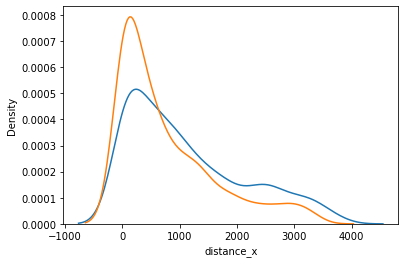



hardneg
18759
18539


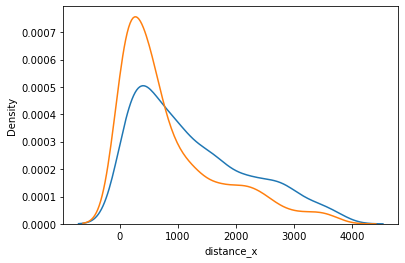

In [20]:
def filter_percentile_for_plot(data, percentile = 0.95):
    # Calculate the 95th percentile value
    percentile_95 = data.quantile(percentile)

    # Filter values less than the 95th percentile
    filtered_values = data[data < percentile_95]
    
    return filtered_values

for p in ['easypos', 'smartneg', 'easyneg', 'hardneg']:
    print(p)
    print(test500[test500.policy == p].distance_x.max())
    print(test500[test500.policy == p].distance_y.max())
    
    if test500[test500.policy == p].distance_x.max() >0:
        sns.kdeplot(filter_percentile_for_plot(test500[test500.policy == p].distance_x))
        sns.kdeplot(filter_percentile_for_plot(test500[test500.policy == p].distance_y))
        plt.show()

    print('\n')

In [21]:
test500 = test500.drop(['start_window_x', 'end_window_x', 'start_window_y', 'end_window_y'], axis = 1)


condition_wrong_easyneg = (test500['policy'] == 'easyneg') &  (test500['distance_x'] == 0) & (test500['distance_y'] == 0) 
condition_wrong_hardneg = (test500['policy'] == 'hardneg') & (test500['distance_x'] == 0) & (test500['distance_y'] == 0)

print(test500[condition_wrong_easyneg].shape[0])
print(test500[condition_wrong_hardneg].shape[0])

test500.loc[condition_wrong_easyneg, 'policy'] = 'smartneg'
test500.loc[condition_wrong_hardneg, 'policy'] = 'easypos'

condition_wrong_smartneg = (test500['policy'] == 'smartneg') & (test500['distance_x'] > 0) & (test500['distance_y'] > 0)
condition_wrong_easypos = (test500['policy'] == 'easypos') & ((test500['distance_x'] > 0) | (test500['distance_y'] > 0))

assert (condition_wrong_smartneg == False).all()
assert (condition_wrong_easypos == False).all()

16
0


In [22]:
test500.to_csv(test500_path, index = False)

### Repeats

In [23]:
test500 = pd.read_csv(test500_path)

In [24]:
test500['start_embedding1'] = test500.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[1].astype(int)
test500['end_embedding1'] = test500.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[2].astype(int)
test500['start_embedding2'] = test500.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[1].astype(int)
test500['end_embedding2'] = test500.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[2].astype(int)

if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

# Apply the function to create the 'feature1' column in the test500 dataframe
test500['feature1'] = test500.apply(get_features1, axis=1, args=(df_repeats,)) # test500['feature1']
test500['feature2'] = test500.apply(get_features2, axis=1, args=(df_repeats,)) # test500['feature1']

test500['full_feature1'] = test500.apply(get_full_overlap_features1, axis=1, args=(df_repeats,)) # test500['feature1']
test500['full_feature2'] = test500.apply(get_full_overlap_features2, axis=1, args=(df_repeats,)) # test500['feature1']

test500 = test500.drop(['start_embedding1', 'end_embedding1', 'start_embedding2', 'end_embedding2'], axis = 1)

test500.to_csv(test500_path, index = False)

### Do the embedding contain the region of interaction?

In [25]:
test500 = pd.read_csv(test500_path)

gene1_coord = test500['gene1'].str.extractall('(.*)_(.*)_(.*)').reset_index()
gene2_coord = test500['gene2'].str.extractall('(.*)_(.*)_(.*)').reset_index()


test500['start_embedding_x'] = gene1_coord[1].astype(int)
test500['end_embedding_x'] = gene1_coord[2].astype(int)

test500['start_embedding_y'] = gene2_coord[1].astype(int)
test500['end_embedding_y'] = gene2_coord[2].astype(int)


diz = {}
for _, row in tqdm(test500.iterrows(), total = test500.shape[0]):
    g1, g2 = row.g1, row.g2
    x1,x2,y1,y2 = row.start_embedding_x, row.end_embedding_x, row.start_embedding_y, row.end_embedding_y

    couple_name = g1 + '_' + g2
    assert couple_name in set(df.couples)

    all_interactions = df[df['couples'] == couple_name]

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x1 + df_row.w])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y1 + df_row.h])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)

    diz[row.couples] = {'distance_embedding_x':distance_x, 'distance_embedding_y':distance_y}


distances = pd.DataFrame.from_dict(diz, orient = 'index').reset_index().rename({'index':'couples'},axis =1)
test500 = test500.merge(distances, on = 'couples')

test500 = test500.drop(['start_embedding_x',	'end_embedding_x', 'start_embedding_y', 'end_embedding_y'], axis = 1)

if len(set(test500.policy).intersection(['easypos', 'smartneg'])) > 0 :
    assert 0 == np.max(np.max(test500[test500.policy.isin(['easypos', 'smartneg'])][['distance_embedding_x', 'distance_embedding_y']]))

test500.to_csv(test500_path, index = False)

  0%|          | 0/4550 [00:00<?, ?it/s]

### Ci sono alcuni positivi che erano hardneg, ma poi sono diventati easypos perche magari quella coppia aveva piu interazioni, allora l embedding era un hardneg, poi pesco un easyneg da un embedding hardneg e viene fuori un positivo. Potrei rimappare le regioni di interazione corrette per quei positivi, perche per ora i seed_x1, seed_x2, seed_y1, seed_y2 sono quelli di un negativo. Pero li elimino tanto sono pochi...

In [56]:
test500 = pd.read_csv(test500_path)

cond_pos = test500.policy == 'easypos'
cond1 = (test500.x1 > test500.seed_x1)
cond2 = (test500.seed_x2 > test500.x2)
cond3 = (test500.y1 > test500.seed_y1)
cond4 = (test500.seed_y2 > test500.y2)
cond_wrong = cond1|cond2|cond3|cond4

print(f'Verranno eliminati {(cond_pos & cond_wrong).sum()} sample positivi')

test500 = test500[~(cond_pos & cond_wrong)].reset_index(drop = True)

test500.to_csv(test500_path, index = False)

Verranno eliminati 16 sample positivi


# Visualizziamo dove appaiono easypos, hardneg, smartneg, easyneg

In [28]:
how = 'splash'
MAX_RNA_SIZE_TEST = 200

test500_path = os.path.join(metadata_dir, f'{how}{MAX_RNA_SIZE_TEST}.csv')

test500 = pd.read_csv(test500_path)
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

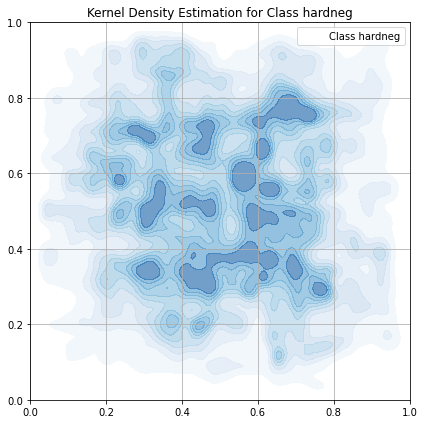

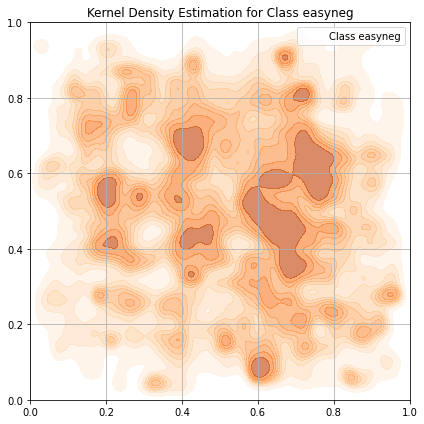

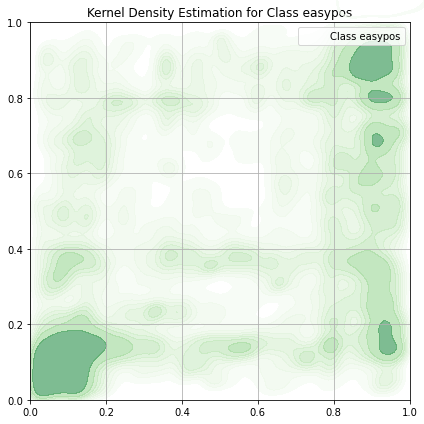

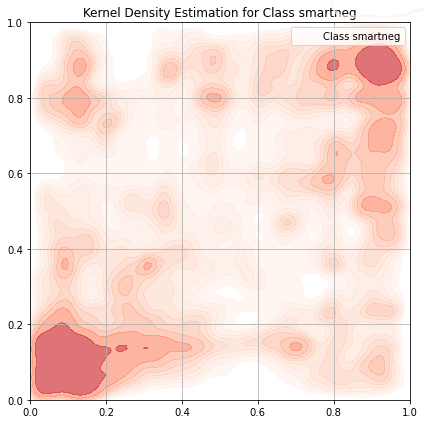

In [26]:
plot_testset_position_based_on_policy(test500, df_genes_nt, n_to_sample_from_each_class = 1_000)

# Check test200 

In [7]:
how = 'ricseq'
MAX_RNA_SIZE_TEST = 200

test500_path = os.path.join(metadata_dir, f'{how}{MAX_RNA_SIZE_TEST}.csv')

test500 = pd.read_csv(test500_path)
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))


if how == 'splash':
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
elif how in ['mario', 'ricseq']:
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))

In [8]:
control_over_test_set(test500, df_nt, df_genes_nt, df, df_genes, df_repeats, MAX_RNA_SIZE_TEST)

  0%|          | 0/35270 [00:00<?, ?it/s]

# Create unique ID with the index

In [4]:
how = 'splash'
MAX_RNA_SIZE_TEST = 200
test500_path = os.path.join(metadata_dir, f'{how}{MAX_RNA_SIZE_TEST}.csv')

test500 = pd.read_csv(test500_path)

if 'df_nt_id' not in test500.columns: # se per caso rieseguo per sbaglio questa cella, questa cosa mi tutela

    test500['df_nt_id'] = test500['couples']
    test500['couples'] = test500.index


test500.to_csv(test500_path, index = False)